# Project: Investigate a Dataset - [PremierLeague]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

This dataset contains more than 25,000 matches in different countries and leagues. We will only investigate England's English Premier League (EPL) from 2008 to 2016


### Questions for Analysis
- Which teams had the best performance ?
- Which teams have improved over the years ?
- What are the factors that affect teams' matches won ?


In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup 
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling



In [2]:
# Loading data
match_df = pd.read_csv('Database_Soccer/Match.csv')
team_df = pd.read_csv('Database_Soccer/Team.csv')

In [3]:
match_df.head(2)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.2
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.6


In [4]:
match_df.head(2)


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.2
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.6



### Data Cleaning
We won't use all columns; therefore we would only select the desired data
 

In [5]:
df_pl = match_df.query('country_id == 1729') #1729 is the id of EPL
df_pl.head(2)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,10.0,1.28,5.5,12.0,1.30,4.75,10.0,1.29,4.5,11.0
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,...,12.0,1.25,6.0,13.0,1.22,5.50,13.0,1.22,5.0,13.0


In [6]:
#Checking for duplicates and null's before dropping match_api_id
df_pl.duplicated().value_counts(), df_pl.isnull().sum().sum()

(False    3040
 dtype: int64,
 13658)

In [7]:
selected_cols = ['season','date','home_team_api_id','away_team_api_id','home_team_goal','away_team_goal','possession']
df_pl = df_pl[selected_cols]
df_pl.head(2)

,season,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,possession
1728,2008/2009,2008-08-17 00:00:00,10260,10261,1,1,<possession><value><comment>56</comment><event...
1729,2008/2009,2008-08-16 00:00:00,9825,8659,1,0,<possession><value><comment>65</comment><event...


Clearly some data are in the incorrect format such as (date and possession)

Firstly, we will change date column format to datetime

In [8]:
df_pl.date = pd.to_datetime(df_pl.date)
df_pl.head(2)

,season,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,possession
1728,2008/2009,2008-08-17,10260,10261,1,1,<possession><value><comment>56</comment><event...
1729,2008/2009,2008-08-16,9825,8659,1,0,<possession><value><comment>65</comment><event...


Next we are going to split possession into home_pos and away_pos by reading through the xml

In [9]:
def set_pos(df):
    """
    Reads through the possession xml and returns home possession and away possession

    Parameters:
    (df) : DataFrame containing the possession column
    """

    homepos_arr = []
    awaypos_arr = []
    for pos in df.possession:
        soup = BeautifulSoup(pos, 'lxml')
        try:
            homepos_arr.append(int(soup.find_all('homepos')[-1].text))
            awaypos_arr.append(int(soup.find_all('awaypos')[-1].text))

        except:
            homepos_arr.append(50)
            awaypos_arr.append(50)
    df['home_pos'] = homepos_arr
    df['away_pos'] = awaypos_arr

The way the function works is as follows:
- Extracts the last value for home and away possessions, append it to an array which will be used as values for the columns.
- However, few matches had no possession data we filled them with 50


In [10]:
set_pos(df_pl)
df_pl.head(2)

,season,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,possession,home_pos,away_pos
1728,2008/2009,2008-08-17,10260,10261,1,1,<possession><value><comment>56</comment><event...,55,45
1729,2008/2009,2008-08-16,9825,8659,1,0,<possession><value><comment>65</comment><event...,66,34


In [11]:
df_pl.drop('possession', axis= 1, inplace=True)

In [12]:
df_pl.head(2)

,season,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_pos,away_pos
1728,2008/2009,2008-08-17,10260,10261,1,1,55,45
1729,2008/2009,2008-08-16,9825,8659,1,0,66,34


In [13]:
df_pl.to_csv('match_v2.csv')

In [14]:
team_df.head(2)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC


In [15]:
# Selecting desired columns
selected_cols = ['team_api_id','team_long_name','team_short_name']
team_df = team_df[selected_cols]
team_df.head()

,team_api_id,team_long_name,team_short_name
0,9987,KRC Genk,GEN
1,9993,Beerschot AC,BAC
2,10000,SV Zulte-Waregem,ZUL
3,9994,Sporting Lokeren,LOK
4,9984,KSV Cercle Brugge,CEB


In [16]:
team_df.to_csv('team.v2.csv')

Now we will merge team data frame with our main dataframe in order to get each team's name from its id

In [17]:
home = pd.merge(df_pl, team_df, how='inner', left_on='home_team_api_id', right_on='team_api_id')

In [18]:
df_pl = pd.merge(home, team_df, how='inner', left_on='away_team_api_id', right_on='team_api_id')

In [19]:
df_pl.head()

,season,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_pos,away_pos,team_api_id_x,team_long_name_x,team_short_name_x,team_api_id_y,team_long_name_y,team_short_name_y
0,2008/2009,2008-08-17,10260,10261,1,1,55,45,10260,Manchester United,MUN,10261,Newcastle United,NEW
1,2010/2011,2010-08-16,10260,10261,3,0,62,38,10260,Manchester United,MUN,10261,Newcastle United,NEW
2,2011/2012,2011-11-26,10260,10261,1,1,70,30,10260,Manchester United,MUN,10261,Newcastle United,NEW
3,2012/2013,2012-12-26,10260,10261,4,3,53,47,10260,Manchester United,MUN,10261,Newcastle United,NEW
4,2013/2014,2013-12-07,10260,10261,0,1,48,52,10260,Manchester United,MUN,10261,Newcastle United,NEW


In [20]:
# Renaming and dropping columns
rename_dict = {'team_long_name_x':'home_long', 'team_long_name_y':'away_long', 'team_short_name_x':'home_short', 'team_short_name_y':'away_short'}
to_drop = ['home_team_api_id', 'away_team_api_id', 'team_api_id_x', 'team_api_id_y']
df_pl = df_pl.rename(rename_dict, axis=1).drop(to_drop, axis=1)

In [21]:
df_pl.head(2)

,season,date,home_team_goal,away_team_goal,home_pos,away_pos,home_long,home_short,away_long,away_short
0,2008/2009,2008-08-17,1,1,55,45,Manchester United,MUN,Newcastle United,NEW
1,2010/2011,2010-08-16,3,0,62,38,Manchester United,MUN,Newcastle United,NEW


In [22]:
df_pl.to_csv('match_v3.csv', index=False)

Then we create a function that determines the winner in each match

In [23]:
def win(df):
    """
    Returns the game winner from a given dataframe

    Parameters:
    (df) : Desired DataFrame containing home and away stats
    """
    #0: home goals
    #1: away goals
    #2: home short name
    #3: away short name
    if df[0] > df[1]:
        return df[2]
    elif df[1] > df[0]:
        return df[3]
    else:
        return 'DRAW'

In [24]:
df_pl['winner'] = df_pl[['home_team_goal', 'away_team_goal', 'home_short', 'away_short']].apply(win, axis=1)

In [25]:
df_pl.iloc[:15]

,season,date,home_team_goal,away_team_goal,home_pos,away_pos,home_long,home_short,away_long,away_short,winner
0,2008/2009,2008-08-17,1,1,55,45,Manchester United,MUN,Newcastle United,NEW,DRAW
1,2010/2011,2010-08-16,3,0,62,38,Manchester United,MUN,Newcastle United,NEW,MUN
2,2011/2012,2011-11-26,1,1,70,30,Manchester United,MUN,Newcastle United,NEW,DRAW
3,2012/2013,2012-12-26,4,3,53,47,Manchester United,MUN,Newcastle United,NEW,MUN
4,2013/2014,2013-12-07,0,1,48,52,Manchester United,MUN,Newcastle United,NEW,NEW
5,2014/2015,2014-12-26,3,1,62,38,Manchester United,MUN,Newcastle United,NEW,MUN
6,2015/2016,2015-08-22,0,0,69,31,Manchester United,MUN,Newcastle United,NEW,DRAW
7,2008/2009,2008-08-30,3,0,53,47,Arsenal,ARS,Newcastle United,NEW,ARS
8,2010/2011,2010-11-07,0,1,49,51,Arsenal,ARS,Newcastle United,NEW,NEW
9,2011/2012,2012-03-12,2,1,59,41,Arsenal,ARS,Newcastle United,NEW,ARS


<a id='eda'></a>
## Exploratory Data Analysis

After Cleaning most of the needed data, we will now visualize some data to answer our questions

### Research Question 1: Which teams had the best performance ?

In [26]:
# Create a dataframe with teams' names and number of matches won
df_wins = df_pl.query('winner != "DRAW"')
df_wins = df_wins.groupby('winner', as_index=False)['home_long'].count()
df_wins.sort_values('home_long', ascending=False, inplace=True)
df_wins.head()

,winner,home_long
18,MUN,192
9,CHE,176
16,MCI,175
0,ARS,170
28,TOT,151


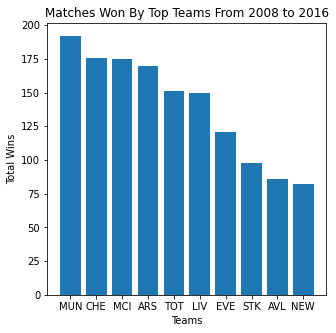

In [27]:
plt.figure(figsize=(5,5))
plt.xlabel('Teams')
plt.ylabel('Total Wins')
plt.title('Matches Won By Top Teams From 2008 to 2016')
plt.bar(df_wins.winner.iloc[:10], df_wins.home_long.iloc[:10]);

Clearly MUN, CHE, MCI Were the top 3 winning teams

### Now visualizing top scoring teams 

In [28]:
#Creating a dataframe
df_goals = df_pl[['home_team_goal', 'away_team_goal', 'home_short', 'away_short']]

home_goals = df_goals.groupby(['home_short'], as_index=False)[['home_team_goal']].sum()
away_goals = df_goals.groupby(['away_short'])[['away_team_goal']].sum()


In [29]:
#Merging datasets
df_goals = pd.merge(home_goals, away_goals, how='inner', left_on='home_short', right_on='away_short')
df_goals['total_goals'] = df_goals.home_team_goal+df_goals.away_team_goal
df_goals.sort_values(by=['total_goals'],ascending=False, inplace=True)

In [30]:
df_goals.head()

,home_short,home_team_goal,away_team_goal,total_goals
16,MCI,365,241,606
9,CHE,333,250,583
18,MUN,338,244,582
0,ARS,306,267,573
15,LIV,294,237,531


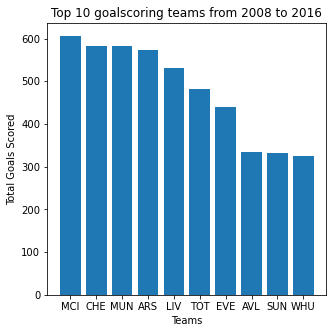

In [31]:
plt.figure(figsize=(5,5))
plt.xlabel('Teams')
plt.ylabel('Total Goals Scored')
plt.title('Top 10 goalscoring teams from 2008 to 2016')
plt.bar(df_goals.home_short.iloc[:10], df_goals.total_goals.iloc[:10]);

Again, MUN, CHE, MCI are in top 3


### Research Question 2: Which teams have most improved ?

Change in goals scored might be a good indicator of improvement

In [32]:
# Creating a dataframe for 2008
df_goals_08 = df_pl.query('season == "2008/2009"')
home_goals_08 = df_goals_08.groupby(['home_short'], as_index=False)[['home_team_goal']].sum()
away_goals_08 = df_goals_08.groupby(['away_short'])[['away_team_goal']].sum()

df_goals_08 = pd.merge(home_goals_08, away_goals_08, how='inner', left_on='home_short', right_on='away_short')
df_goals_08['total_goals_08'] = df_goals_08.home_team_goal+df_goals_08.away_team_goal

df_goals_08.sort_values(by=['total_goals_08'],ascending=False, inplace=True)

df_goals_08.head()


,home_short,home_team_goal,away_team_goal,total_goals_08
8,LIV,41,36,77
4,CHE,33,35,68
11,MUN,43,25,68
0,ARS,31,37,68
9,MCI,40,18,58


In [33]:
# Creating a dataframe for 2016
df_goals_16 = df_pl.query('season == "2015/2016"')
home_goals_16 = df_goals_16.groupby(['home_short'], as_index=False)[['home_team_goal']].sum()
away_goals_16 = df_goals_16.groupby(['away_short'])[['away_team_goal']].sum()

df_goals_16 = pd.merge(home_goals_16, away_goals_16, how='inner', left_on='home_short', right_on='away_short')
df_goals_16['total_goals_16'] = df_goals_16.home_team_goal+df_goals_16.away_team_goal

df_goals_16.sort_values(by=['total_goals_16'],ascending=False, inplace=True)
df_goals_16.head()

,home_short,home_team_goal,away_team_goal,total_goals_16
8,MCI,47,24,71
16,TOT,35,34,69
6,LEI,35,33,68
0,ARS,31,34,65
19,WHU,34,31,65


In [34]:
#Merging datasets
df_goals_mix = pd.merge(df_goals_08, df_goals_16, how='inner', left_on='home_short', right_on='home_short')
df_goals_mix['delta_goals'] = df_goals_mix.total_goals_16-df_goals_mix.total_goals_08
df_goals_mix.sort_values(by='delta_goals', ascending=False, inplace=True)

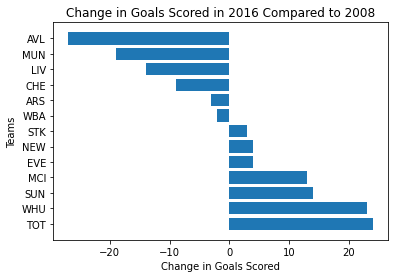

In [35]:
plt.title('Change in Goals Scored in 2016 Compared to 2008')
plt.xlabel('Change in Goals Scored')
plt.ylabel('Teams')
plt.barh(df_goals_mix.home_short, df_goals_mix.delta_goals);

TOT and WHU both scored more than 20 goals with respect to 2008 season. Impressive

#### Wins can also indicate improvement

In [36]:
#Creating 2008 Dataframe
df_wins_08 = df_pl[df_pl['season']=='2008/2009'].query('winner != "DRAW"')
df_wins_08 = df_wins_08.groupby('winner', as_index=False)['home_long'].count()
df_wins_08.sort_values('home_long', ascending=False, inplace=True)
df_wins_08.head()

,winner,home_long
11,MUN,28
4,CHE,25
8,LIV,25
0,ARS,20
5,EVE,17


In [37]:
#Creating 2016 Dataframe
df_wins_16 = df_pl[df_pl['season']=='2015/2016'].query('winner != "DRAW"')
df_wins_16 = df_wins_16.groupby('winner', as_index=False)['home_long'].count()
df_wins_16.sort_values('home_long', ascending=False, inplace=True)
df_wins_16.head()

,winner,home_long
6,LEI,23
0,ARS,20
16,TOT,19
9,MUN,19
8,MCI,19


In [38]:
#Merging datasets
df_wins_mix = pd.merge(df_wins_08, df_wins_16, how='inner', left_on='winner', right_on='winner')
df_wins_mix['delta_wins'] = df_wins_mix.home_long_y-df_wins_mix.home_long_x
df_wins_mix.sort_values(by='delta_wins', ascending=False, inplace=True)
df_wins_mix.head()

,winner,home_long_x,home_long_y,delta_wins
8,TOT,14,19,5
6,MCI,15,19,4
7,WHU,14,16,2
9,STK,12,14,2
11,WBA,8,10,2


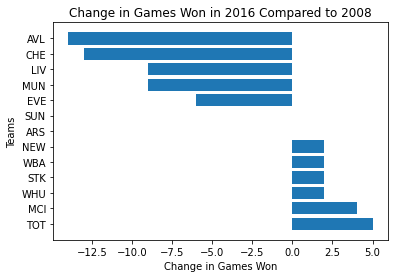

In [39]:
plt.title('Change in Games Won in 2016 Compared to 2008')
plt.xlabel('Change in Games Won')
plt.ylabel('Teams')
plt.barh(df_wins_mix.winner, df_wins_mix.delta_wins);

TOT and MCI were top 2 improved teams

### Research Question 3: Which factors affected teams' matches won ?

#### Goals ?

In [40]:
#Merging datasets
df_goals_wins = pd.merge(df_goals, df_wins, how='inner', left_on='home_short', right_on='winner')
df_goals_wins.head()

,home_short,home_team_goal,away_team_goal,total_goals,winner,home_long
0,MCI,365,241,606,MCI,175
1,CHE,333,250,583,CHE,176
2,MUN,338,244,582,MUN,192
3,ARS,306,267,573,ARS,170
4,LIV,294,237,531,LIV,150


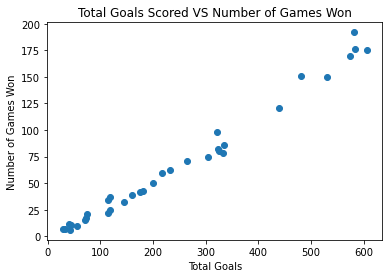

In [41]:
plt.title('Total Goals Scored VS Number of Games Won')
plt.xlabel('Total Goals')
plt.ylabel('Number of Games Won')
plt.scatter(df_goals_wins.total_goals, df_goals_wins.home_long);

It is very clear that the more you score the more games you'll win

#### Possession ?

Home:

In [42]:
#Merging Datasets
df_pos = df_pl.groupby('winner', as_index=False)['home_pos'].mean()
df_pos_wins = pd.merge(df_pos, df_wins, how='inner', left_on='winner', right_on='winner')
df_pos_wins.tail()

,winner,home_pos,home_long
29,WAT,53.750000,12
30,WBA,51.826667,75
31,WHU,51.212500,80
32,WIG,49.200000,50
33,WOL,53.440000,25


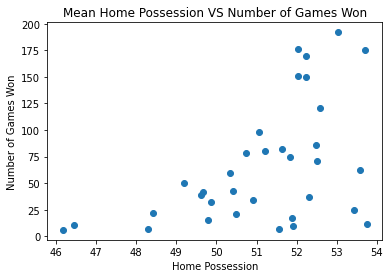

In [43]:
plt.title('Mean Home Possession VS Number of Games Won')
plt.xlabel('Home Possession')
plt.ylabel('Number of Games Won')
plt.scatter(df_pos_wins.home_pos, df_pos_wins.home_long);

There is a positive corelation between home possession and games won

Away:

In [44]:
df_pos = df_pl.groupby('winner', as_index=False)['away_pos'].mean()
df_pos_wins = pd.merge(df_pos, df_wins, how='inner', left_on='winner', right_on='winner')
df_pos_wins.tail()

,winner,away_pos,home_long
29,WAT,46.250000,12
30,WBA,48.173333,75
31,WHU,48.787500,80
32,WIG,50.800000,50
33,WOL,46.560000,25


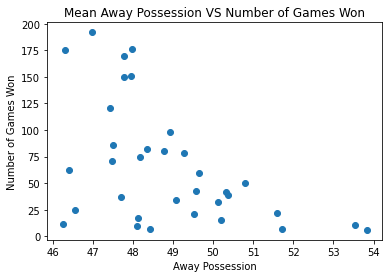

In [45]:
plt.title('Mean Away Possession VS Number of Games Won')
plt.xlabel('Away Possession')
plt.ylabel('Number of Games Won')
plt.scatter(df_pos_wins.away_pos, df_pos_wins.home_long);

Seems that Away Possession does not affect games won that much

<a id='conclusions'></a>
## Conclusions


In conclusion, performance-wise, Manchester United, Manchester City, and Chelsea were the most well-performed teams from 2008 to 2016. In fact, they are top 3 in most goals scored as well as most wins. Next, Tottenham and Westham had the highest increase in goals scored in a season. In addition, Tottenham alongside Manchester City had the highest increase in games won. Hence, We might consider Tottenham one of the most improved teams. 
There were several factors that affect teams' winning chances. For instance, total goals scored had a strong positive correlation with wins. In addition, possession contributed in winning as well, however it was home possession that contributed the most.


### Limitations
There were however some limitations. For instance, some teams did not participate in all seasons, which can affect team's improvement stats.
For that you might visitt Premier League website to investigate all teams' stats